The idea is to use DCTR for parameterized reweighting in order to do anomaly detection.  The setting is that there is some feature m where the signal is expected to be resonant.  There are other features x that can be used to enhance signal over background.  In the CWoLa hunting methodology, one can only use features x that don't sculpt a bump (a looser requirement than being independent from m, but clearly that would be sufficient); then a parameteric fit based on the sidebands is used to estimate the background in the signal region.  In this new approach, a DCTR model is used to reweight simulation to data in away from the signal region.  This model is parameterized in m and then interpolated to the signal region.  The reweighted simulation in the signal region can then be used to make a classifier (using x) as well as estimate the background.  There is no need for a sideband fit if the reweighting works well.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/lib/python3.6/site-packages/tensorflow/py

Let's make signal region and sideband regions.

In [25]:
N_data = 1000000
N_MC = 1000000
N_signal = 10000

m_background_data = np.random.uniform(0,1,N_data)
m_background_MC = np.random.uniform(0,1,N_MC)
m_signal = np.random.normal(0.5,0.1,N_signal)

x_background_data = np.random.normal(-0.5+2.*m_background_data,0.8,N_data)
x_background_MC = np.random.normal(-0.4+2.*m_background_MC,1.1,N_MC)
x_signal = np.random.normal(1.5,0.8,N_signal)

Text(0,0.5,'Normalized to unity')

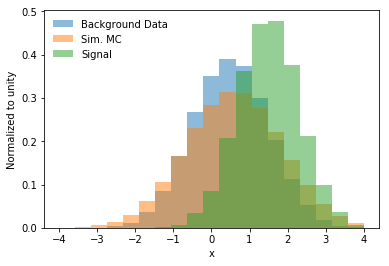

In [26]:
_,_,_=plt.hist(x_background_data,bins=np.linspace(-4,4,20),density=True,alpha=0.5,label="Background Data")
_,_,_=plt.hist(x_background_MC,bins=np.linspace(-4,4,20),density=True,alpha=0.5,label="Sim. MC")
_,_,_=plt.hist(x_signal,bins=np.linspace(-4,4,20),density=True,alpha=0.5,label="Signal")
plt.legend(frameon=False)
plt.xlabel("x")
plt.ylabel("Normalized to unity")

Text(0,0.5,'x')

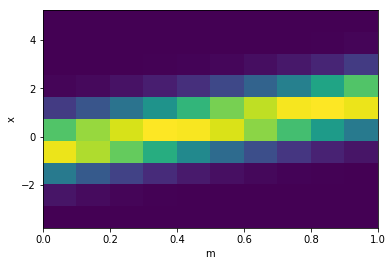

In [27]:
plt.hist2d(m_background_data,x_background_data)
plt.xlabel("m")
plt.ylabel("x")

In [28]:
SR_low = 0.4
SR_high = 0.6

In [29]:
#Prepare the DCTR training, excluding the SR.

Data_labels = np.ones(len(m_background_data))
Sim_labels = np.zeros(len(m_background_MC))

X_background_data = np.reshape(np.concatenate([m_background_data,x_background_data]),[len(m_background_data),2],order='F')
X_signal = np.reshape(np.concatenate([m_signal,x_signal]),[len(m_signal),2],order='F')
X_background_sim = np.reshape(np.concatenate([m_background_MC,x_background_MC]),[len(m_background_MC),2],order='F')

X = np.concatenate([X_background_data[(m_background_data < SR_low) + (m_background_data > SR_high)],X_background_sim[(m_background_MC < SR_low) + (m_background_MC > SR_high)]])
Y = np.concatenate([Data_labels[(m_background_data < SR_low) + (m_background_data > SR_high)],Sim_labels[(m_background_MC < SR_low) + (m_background_MC > SR_high)]])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [37]:
cmodel = Sequential()
cmodel.add(Dense(64, input_dim=2, activation='elu'))
cmodel.add(Dropout(0.1))
cmodel.add(Dense(128, activation='elu'))
cmodel.add(Dropout(0.1))
cmodel.add(Dense(256, activation='elu'))
cmodel.add(Dropout(0.1))
cmodel.add(Dense(32, activation='elu'))
cmodel.add(Dropout(0.1))
cmodel.add(Dense(1, activation='sigmoid'))
cmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
cmodel.fit(X_train,Y_train, epochs=5, batch_size=200)

Epoch 1/5
800049/800049 [==============================] - 66s 83us/step - loss: 0.6735 - acc: 0.5714
Epoch 2/5
800049/800049 [==============================] - 64s 80us/step - loss: 0.6703 - acc: 0.5763
Epoch 3/5
800049/800049 [==============================] - 64s 81us/step - loss: 0.6698 - acc: 0.5771
Epoch 4/5
800049/800049 [==============================] - 64s 80us/step - loss: 0.6696 - acc: 0.5773
Epoch 5/5
800049/800049 [==============================] - 63s 79us/step - loss: 0.6695 - acc: 0.5769


In [35]:
weights_test = cmodel.predict(X_test)
weights_test = weights_test / (1.-weights_test)

Text(0,0.5,'Normalized to unity')

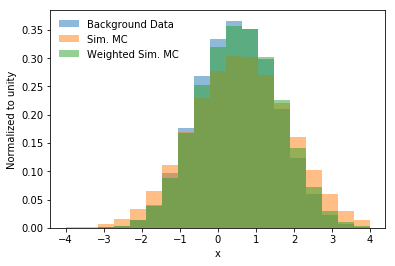

In [36]:
_,_,_=plt.hist(X_test[Y_test==1][:,1],bins=np.linspace(-4,4,20),density=True,alpha=0.5,label="Background Data")
_,_,_=plt.hist(X_test[Y_test==0][:,1],bins=np.linspace(-4,4,20),density=True,alpha=0.5,label="Sim. MC")
_,_,_=plt.hist(X_test[Y_test==0][:,1],bins=np.linspace(-4,4,20),density=True,weights = weights_test[Y_test==0],alpha=0.5,label="Weighted Sim. MC")
plt.legend(frameon=False)
plt.xlabel("x")
plt.ylabel("Normalized to unity")

In [39]:
X_SR = np.concatenate([X_background_data[(m_background_data > SR_low) * (m_background_data < SR_high)],X_background_sim[(m_background_MC > SR_low) * (m_background_MC < SR_high)]])
Y_SR = np.concatenate([Data_labels[(m_background_data > SR_low) * (m_background_data < SR_high)],Sim_labels[(m_background_MC > SR_low) * (m_background_MC < SR_high)]])
X_train_SR, X_test_SR, Y_train_SR, Y_test_SR = train_test_split(X_SR, Y_SR, test_size=0.5)

In [40]:
weights_test_SR = cmodel.predict(X_test_SR)
weights_test_SR = weights_test_SR / (1.-weights_test_SR)

Text(0,0.5,'Normalized to unity')

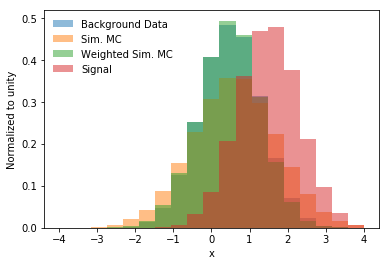

In [41]:
#Now, let's check in the SR.
_,_,_=plt.hist(X_test_SR[Y_test_SR==1][:,1],bins=np.linspace(-4,4,20),density=True,alpha=0.5,label="Background Data")
_,_,_=plt.hist(X_test_SR[Y_test_SR==0][:,1],bins=np.linspace(-4,4,20),density=True,alpha=0.5,label="Sim. MC")
_,_,_=plt.hist(X_test_SR[Y_test_SR==0][:,1],bins=np.linspace(-4,4,20),density=True,weights = weights_test_SR[Y_test_SR==0],alpha=0.5,label="Weighted Sim. MC")
_,_,_=plt.hist(x_signal,bins=np.linspace(-4,4,20),density=True,alpha=0.5,label="Signal")
plt.legend(frameon=False)
plt.xlabel("x")
plt.ylabel("Normalized to unity")

Next, let's train a classifier to distinguish the reweighted signal region simulation from the data (with and without signal)

In [43]:
#First, no signal
weights_train_SR = cmodel.predict(X_train_SR)
weights_train_SR = weights_train_SR / (1.-weights_train_SR)
W_train_SR = []
for i in range(len(Y_train_SR)):
    if (Y_train_SR[i]==1):
        W_train_SR += [1.]
    else:
        W_train_SR += [weights_train_SR[i]]
        pass
    pass
W_train_SR=np.array(W_train_SR)

weights_test_SR = cmodel.predict(X_test_SR)
weights_test_SR = weights_test_SR / (1.-weights_test_SR)
W_test_SR = []
for i in range(len(Y_test_SR)):
    if (weights_test_SR[i]==1):
        W_test_SR += [1.]
    else:
        W_test_SR += [weights_test_SR[i]]
        pass
    pass
W_test_SR = np.array(W_test_SR)
W_test_SR = W_test_SR

In [45]:
amodel = Sequential()
amodel.add(Dense(10, input_dim=2, activation='elu'))
amodel.add(Dropout(0.1))
amodel.add(Dense(20, activation='elu'))
amodel.add(Dropout(0.1))
amodel.add(Dense(1, activation='sigmoid'))
amodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
amodel.fit(X_train_SR,Y_train_SR, epochs=5, sample_weight=W_train_SR,batch_size=200)

Epoch 1/5
199950/199950 [==============================] - 6s 29us/step - loss: 0.7260 - acc: 0.4798
Epoch 2/5
199950/199950 [==============================] - 5s 23us/step - loss: 0.7250 - acc: 0.4725
Epoch 3/5
199950/199950 [==============================] - 4s 22us/step - loss: 0.7250 - acc: 0.4697
Epoch 4/5
199950/199950 [==============================] - 4s 22us/step - loss: 0.7250 - acc: 0.4714
Epoch 5/5
199950/199950 [==============================] - 4s 22us/step - loss: 0.7249 - acc: 0.4717


In [47]:
amodel_nodctr = Sequential()
amodel_nodctr.add(Dense(10, input_dim=2, activation='elu'))
amodel_nodctr.add(Dropout(0.1))
amodel_nodctr.add(Dense(20, activation='elu'))
amodel_nodctr.add(Dropout(0.1))
amodel_nodctr.add(Dense(1, activation='sigmoid'))
amodel_nodctr.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
amodel_nodctr.fit(X_train_SR,Y_train_SR, epochs=5,batch_size=200)

Epoch 1/5
199950/199950 [==============================] - 6s 30us/step - loss: 0.6803 - acc: 0.5561
Epoch 2/5
199950/199950 [==============================] - 4s 22us/step - loss: 0.6731 - acc: 0.5731
Epoch 3/5
199950/199950 [==============================] - 4s 22us/step - loss: 0.6724 - acc: 0.5744
Epoch 4/5
199950/199950 [==============================] - 4s 22us/step - loss: 0.6719 - acc: 0.5743
Epoch 5/5
199950/199950 [==============================] - 4s 22us/step - loss: 0.6711 - acc: 0.5764


In [50]:
#Second, with signal
X_SR_wsig = np.concatenate([np.concatenate([X_background_data[(m_background_data > SR_low)*(m_background_data < SR_high)],X_signal]),X_background_sim[(m_background_MC > SR_low)*(m_background_MC < SR_high)]])
Y_SR_wsig = np.concatenate([np.concatenate([Data_labels[(m_background_data > SR_low)*(m_background_data < SR_high)],np.ones(len(X_signal))]),Sim_labels[(m_background_MC > SR_low)*(m_background_MC < SR_high)]])
X_train_SR_wsig, X_test_SR_wsig, Y_train_SR_wsig, Y_test_SR_wsig = train_test_split(X_SR_wsig, Y_SR_wsig, test_size=0.5)

weights_train_SR_withsig = cmodel.predict(X_train_SR_wsig)
weights_train_SR_withsig = weights_train_SR_withsig / (1.-weights_train_SR_withsig)
W_train_SR_withsig = []
for i in range(len(Y_train_SR_wsig)):
    if (weights_train_SR_withsig[i]==1):
        W_train_SR_withsig += [1.]
    else:
        W_train_SR_withsig += [weights_train_SR_withsig[i]]
        pass
    pass
W_train_SR_withsig = np.array(W_train_SR_withsig)
W_train_SR_withsig = W_train_SR_withsig

weights_test_SR_withsig = cmodel.predict(X_test_SR_wsig)
weights_test_SR_withsig = weights_test_SR_withsig / (1.-weights_test_SR_withsig)
W_test_SR_withsig = []
for i in range(len(Y_test_SR_wsig)):
    if (weights_test_SR_withsig[i]==1):
        W_test_SR_withsig += [1.]
    else:
        W_test_SR_withsig += [weights_test_SR_withsig[i]]
        pass
    pass
W_test_SR_withsig = np.array(W_test_SR_withsig)
W_test_SR_withsig = W_test_SR_withsig

In [51]:
amodel_wsig = Sequential()
amodel_wsig.add(Dense(10, input_dim=2, activation='elu'))
amodel_wsig.add(Dropout(0.1))
amodel_wsig.add(Dense(20, activation='elu'))
amodel_wsig.add(Dropout(0.1))
amodel_wsig.add(Dense(1, activation='sigmoid'))
amodel_wsig.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
amodel_wsig.fit(X_train_SR_wsig,Y_train_SR_wsig, epochs=5, sample_weight=W_train_SR_withsig[:,0],batch_size=200)

Epoch 1/5
204950/204950 [==============================] - 6s 29us/step - loss: 0.8058 - acc: 0.5447
Epoch 2/5
204950/204950 [==============================] - 4s 22us/step - loss: 0.8022 - acc: 0.5632
Epoch 3/5
204950/204950 [==============================] - 4s 21us/step - loss: 0.8011 - acc: 0.5677
Epoch 4/5
204950/204950 [==============================] - 5s 22us/step - loss: 0.8008 - acc: 0.5685
Epoch 5/5
204950/204950 [==============================] - 4s 22us/step - loss: 0.8002 - acc: 0.5705


In [55]:
#One more training without weights

In [56]:
#Now, some ROC curves
predicts = amodel.predict(X_test_SR)
roc = roc_curve(Y_test_SR,predicts,sample_weight=W_test_SR)

predicts_nodctr = amodel_nodctr.predict(X_test_SR)
roc_nodctr = roc_curve(Y_test_SR,predicts_nodctr)

predicts_wsig = amodel_wsig.predict(X_test_SR_wsig)
roc_wsig = roc_curve(Y_test_SR_wsig,predicts_wsig,sample_weight=W_test_SR_withsig)

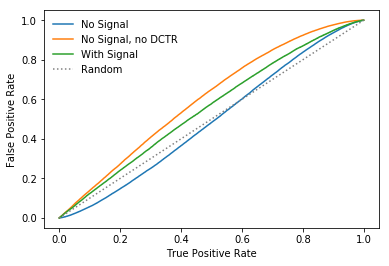

In [57]:
plt.plot(roc[0],roc[1],label="No Signal")
plt.plot(roc_nodctr[0],roc_nodctr[1],label="No Signal, no DCTR")
plt.plot(roc_wsig[0],roc_wsig[1],label="With Signal")
plt.plot([0,1],[0,1],color="gray",ls=":",label="Random")
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.legend(frameon=False)